# Potato Plant Modelling

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/datasets/Potato.zip

In [ ]:
datagen = ImageDataGenerator(validation_split=0.2)

# get training data
train_ds = datagen.flow_from_directory(
    '/content/Potato',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # set as training data
    seed=42
)

# get validation data
val_ds = datagen.flow_from_directory(
    '/content/Potato',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # set as validation data
    seed=42,
    shuffle= False
)

Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


In [ ]:
train_ds.class_indices

{'Potato_Early_blight': 0, 'Potato_Late_blight': 1, 'Potato_healthy': 2}

## Creating models and evaluating

In [ ]:
es = EarlyStopping(patience = 5)

model1 = Sequential()

model1.add(layers.Input(shape=(256,256,3)))
model1.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Dense Layers
model1.add(Dense(64, activation='relu'))

# Output
model1.add(Dense(3, activation='softmax'))

model1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
model1.input_shape

(None, 256, 256, 3)

In [ ]:
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 246016)          

In [ ]:
h = model1.fit(train_ds, validation_data=val_ds, epochs= 10)

Epoch 1/10
54/54 [==============================] - 6s 90ms/step - loss: 1.0894 - accuracy: 0.7073 - val_loss: 0.3563 - val_accuracy: 0.8744
Epoch 2/10
54/54 [==============================] - 5s 91ms/step - loss: 0.2958 - accuracy: 0.8827 - val_loss: 0.4155 - val_accuracy: 0.8465
Epoch 3/10
54/54 [==============================] - 5s 89ms/step - loss: 0.1987 - accuracy: 0.9210 - val_loss: 0.1664 - val_accuracy: 0.9465
Epoch 4/10
54/54 [==============================] - 5s 88ms/step - loss: 0.0834 - accuracy: 0.9692 - val_loss: 0.1564 - val_accuracy: 0.9419
Epoch 5/10
54/54 [==============================] - 5s 88ms/step - loss: 0.0549 - accuracy: 0.9826 - val_loss: 0.1804 - val_accuracy: 0.9349
Epoch 6/10
54/54 [==============================] - 5s 90ms/step - loss: 0.0633 - accuracy: 0.9797 - val_loss: 0.1857 - val_accuracy: 0.9419
Epoch 7/10
54/54 [==============================] - 5s 93ms/step - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.1881 - val_accuracy: 0.9372
Epoch 8/10
54

Prompted CHAT-GPT 4 to help grab the labels information from the validation dataset and get it into a numpy array, so that we can use that to make a confusion matrix.

In [ ]:
def model_preds(model):
  '''
  This function will return the y_true_classes and y_pred_clasess
  Which will allows us to build a confusion matrix
  '''
  
  y_true_classes = val_ds.labels

  y_pred_classes = model.predict(val_ds)

  y_pred_classes = np.argmax(y_pred_classes, axis=1)

  return (y_true_classes, y_pred_classes)

14/14 [==============================] - 1s 71ms/step


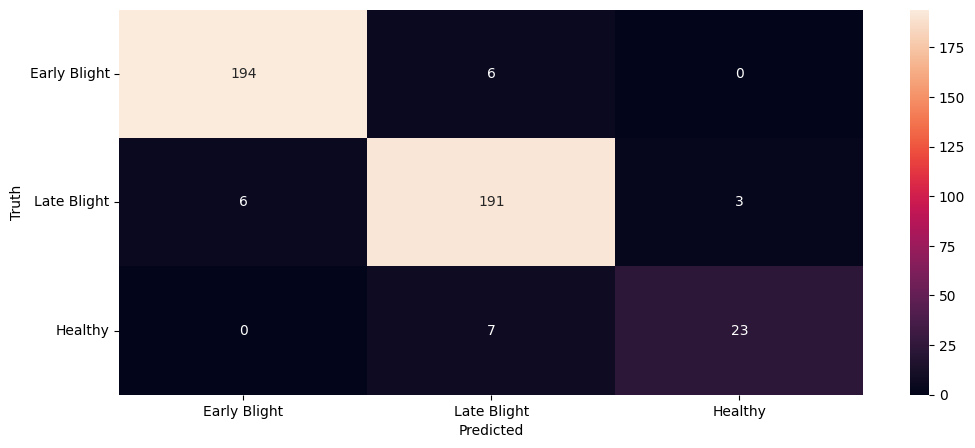

In [ ]:
y_true_classes, y_pred_classes = model_preds(model1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Potato_Early_blight       0.97      0.97      0.97       200
 Potato_Late_blight       0.94      0.95      0.95       200
     Potato_healthy       0.88      0.77      0.82        30

           accuracy                           0.95       430
          macro avg       0.93      0.90      0.91       430
       weighted avg       0.95      0.95      0.95       430



This model performs well, but let's add some more hidden layers and early stopping now. 

In [ ]:
es = EarlyStopping(patience = 5)

model2 = Sequential()

model2.add(layers.Input(shape=(256,256,3)))
model2.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

# Dense Layers
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))

# Output
model2.add(Dense(3, activation='softmax'))

model2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model2.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
54/54 [==============================] - 7s 91ms/step - loss: 1.0116 - accuracy: 0.6632 - val_loss: 0.4122 - val_accuracy: 0.8767
Epoch 2/20
54/54 [==============================] - 5s 90ms/step - loss: 0.3299 - accuracy: 0.8786 - val_loss: 0.2048 - val_accuracy: 0.9209
Epoch 3/20
54/54 [==============================] - 5s 91ms/step - loss: 0.1926 - accuracy: 0.9297 - val_loss: 0.3570 - val_accuracy: 0.8349
Epoch 4/20
54/54 [==============================] - 5s 92ms/step - loss: 0.0926 - accuracy: 0.9686 - val_loss: 0.4662 - val_accuracy: 0.8535
Epoch 5/20
54/54 [==============================] - 5s 90ms/step - loss: 0.1049 - accuracy: 0.9640 - val_loss: 0.1352 - val_accuracy: 0.9605
Epoch 6/20
54/54 [==============================] - 5s 88ms/step - loss: 0.0372 - accuracy: 0.9861 - val_loss: 0.1194 - val_accuracy: 0.9581
Epoch 7/20
54/54 [==============================] - 5s 90ms/step - loss: 0.0425 - accuracy: 0.9832 - val_loss: 0.2055 - val_accuracy: 0.9326
Epoch 8/20
54

14/14 [==============================] - 1s 65ms/step


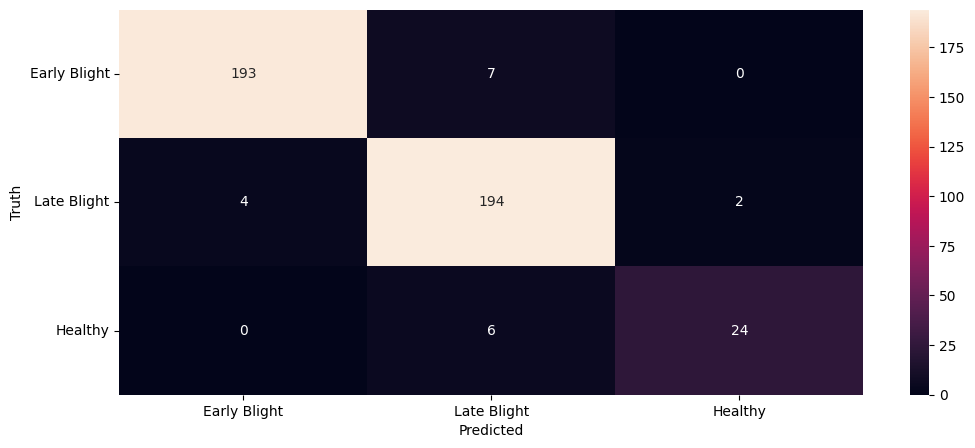

In [ ]:
y_true_classes, y_pred_classes = model_preds(model2)

cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Potato_Early_blight       0.98      0.96      0.97       200
 Potato_Late_blight       0.94      0.97      0.95       200
     Potato_healthy       0.92      0.80      0.86        30

           accuracy                           0.96       430
          macro avg       0.95      0.91      0.93       430
       weighted avg       0.96      0.96      0.96       430



The test accuracy got better, so that's good. Now let's try adding a dropout layer.

In [ ]:
es = EarlyStopping(patience = 5)

model3 = Sequential()

model3.add(layers.Input(shape=(256,256,3)))
model3.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())

# Dense Layers
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))

# Output
model3.add(Dense(3, activation='softmax'))

model3.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model3.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
54/54 [==============================] - 7s 91ms/step - loss: 1.2019 - accuracy: 0.5163 - val_loss: 0.7260 - val_accuracy: 0.8140
Epoch 2/20
54/54 [==============================] - 5s 90ms/step - loss: 0.6552 - accuracy: 0.7544 - val_loss: 0.3650 - val_accuracy: 0.8837
Epoch 3/20
54/54 [==============================] - 5s 87ms/step - loss: 0.4083 - accuracy: 0.8513 - val_loss: 0.2516 - val_accuracy: 0.8930
Epoch 4/20
54/54 [==============================] - 5s 88ms/step - loss: 0.3019 - accuracy: 0.8804 - val_loss: 0.2590 - val_accuracy: 0.8907
Epoch 5/20
54/54 [==============================] - 5s 90ms/step - loss: 0.2681 - accuracy: 0.8844 - val_loss: 0.2248 - val_accuracy: 0.9233
Epoch 6/20
54/54 [==============================] - 5s 87ms/step - loss: 0.1746 - accuracy: 0.9355 - val_loss: 0.1602 - val_accuracy: 0.9349
Epoch 7/20
54/54 [==============================] - 5s 92ms/step - loss: 0.1379 - accuracy: 0.9535 - val_loss: 0.1722 - val_accuracy: 0.9488
Epoch 8/20
54

14/14 [==============================] - 1s 68ms/step


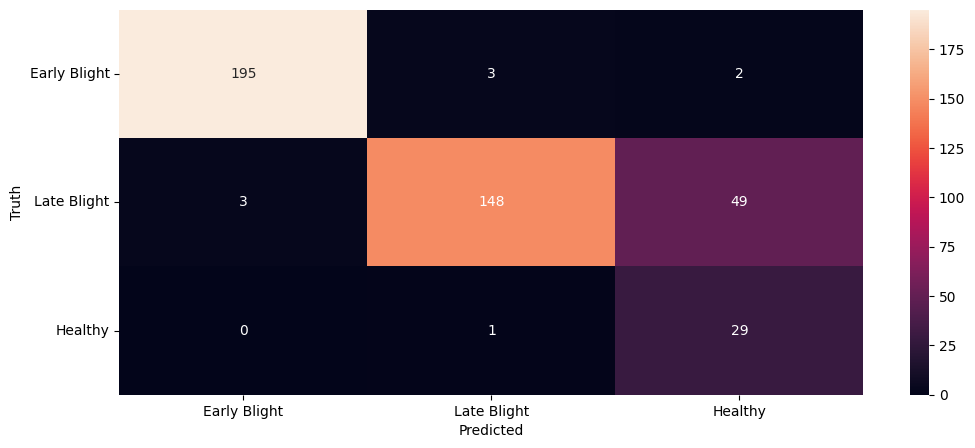

In [ ]:
y_true_classes, y_pred_classes = model_preds(model3)

cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Potato_Early_blight       0.98      0.97      0.98       200
 Potato_Late_blight       0.97      0.74      0.84       200
     Potato_healthy       0.36      0.97      0.53        30

           accuracy                           0.87       430
          macro avg       0.77      0.89      0.78       430
       weighted avg       0.94      0.87      0.88       430



The test accuracy went down, so we will not choose this model over model 2. Let's add another convolutional layer and see what happens.

In [ ]:
es = EarlyStopping(patience = 5)

model4 = Sequential()

model4.add(layers.Input(shape=(256,256,3)))
model4.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())

# Dense Layers
model4.add(Dense(64, activation='relu'))

# Output
model4.add(Dense(3, activation='softmax'))

model4.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model4.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)
     

Epoch 1/20
54/54 [==============================] - 7s 92ms/step - loss: 0.6820 - accuracy: 0.7334 - val_loss: 0.3256 - val_accuracy: 0.8791
Epoch 2/20
54/54 [==============================] - 5s 90ms/step - loss: 0.3758 - accuracy: 0.8676 - val_loss: 0.3337 - val_accuracy: 0.8767
Epoch 3/20
54/54 [==============================] - 5s 88ms/step - loss: 0.2072 - accuracy: 0.9262 - val_loss: 0.2461 - val_accuracy: 0.9116
Epoch 4/20
54/54 [==============================] - 5s 89ms/step - loss: 0.1690 - accuracy: 0.9460 - val_loss: 0.2226 - val_accuracy: 0.9186
Epoch 5/20
54/54 [==============================] - 5s 88ms/step - loss: 0.1279 - accuracy: 0.9553 - val_loss: 0.1527 - val_accuracy: 0.9419
Epoch 6/20
54/54 [==============================] - 5s 89ms/step - loss: 0.0677 - accuracy: 0.9762 - val_loss: 0.1294 - val_accuracy: 0.9512
Epoch 7/20
54/54 [==============================] - 5s 88ms/step - loss: 0.0397 - accuracy: 0.9878 - val_loss: 0.2449 - val_accuracy: 0.9233
Epoch 8/20
54

14/14 [==============================] - 1s 69ms/step


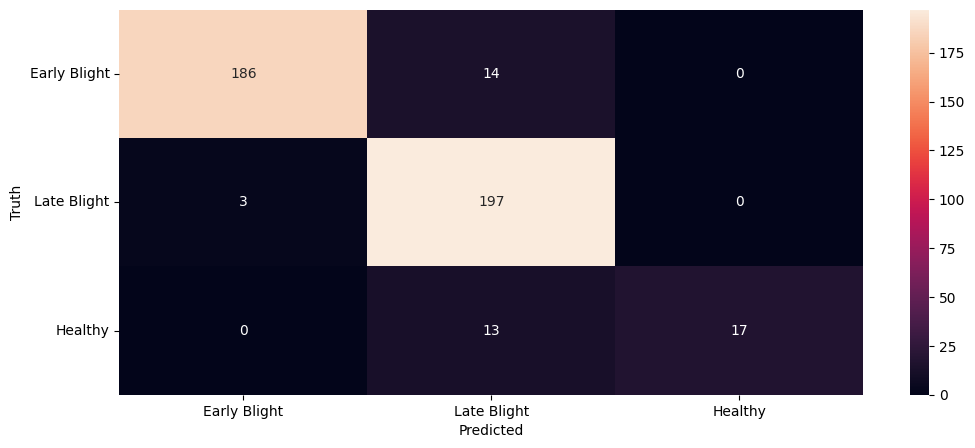

In [ ]:
y_true_classes, y_pred_classes = model_preds(model4)

cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Potato_Early_blight       0.98      0.93      0.96       200
 Potato_Late_blight       0.88      0.98      0.93       200
     Potato_healthy       1.00      0.57      0.72        30

           accuracy                           0.93       430
          macro avg       0.95      0.83      0.87       430
       weighted avg       0.94      0.93      0.93       430



This model does well but still not better than model 2. Let's see if using only one convolutional layer does better than 2 convolutional layers.

In [ ]:
es = EarlyStopping(patience = 5)

model5 = Sequential()

model5.add(layers.Input(shape=(256,256,3)))
model5.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model5.add(Conv2D(64, (3,3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Flatten())

# Dense Layers
model5.add(Dense(64, activation='relu'))

# Output
model5.add(Dense(3, activation='softmax'))

model5.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model5.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
54/54 [==============================] - 6s 90ms/step - loss: 10.7851 - accuracy: 0.6852 - val_loss: 0.3589 - val_accuracy: 0.8814
Epoch 2/20
54/54 [==============================] - 5s 85ms/step - loss: 0.1976 - accuracy: 0.9373 - val_loss: 0.2215 - val_accuracy: 0.9209
Epoch 3/20
54/54 [==============================] - 5s 84ms/step - loss: 0.0621 - accuracy: 0.9843 - val_loss: 0.2096 - val_accuracy: 0.9163
Epoch 4/20
54/54 [==============================] - 5s 89ms/step - loss: 0.0219 - accuracy: 0.9942 - val_loss: 0.1580 - val_accuracy: 0.9465
Epoch 5/20
54/54 [==============================] - 5s 90ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1409 - val_accuracy: 0.9465
Epoch 6/20
54/54 [==============================] - 5s 89ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2157 - val_accuracy: 0.9233
Epoch 7/20
54/54 [==============================] - 5s 84ms/step - loss: 8.9474e-04 - accuracy: 1.0000 - val_loss: 0.1929 - val_accuracy: 0.9279
Epoch 8/

14/14 [==============================] - 1s 64ms/step


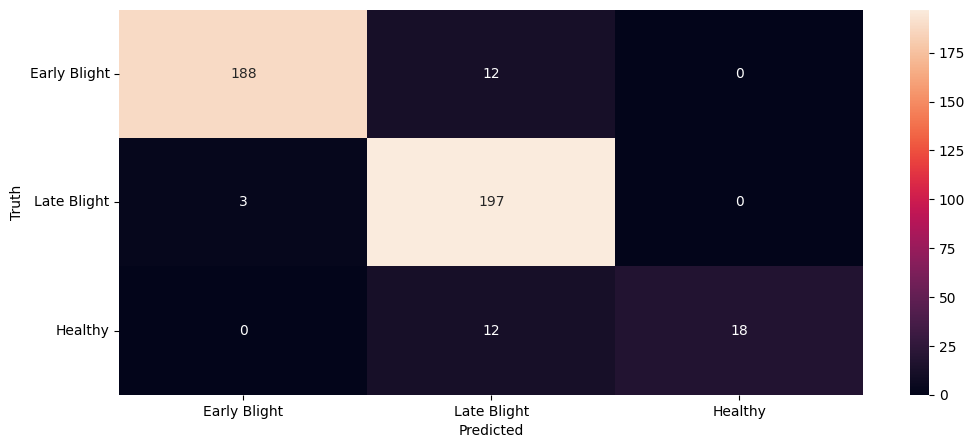

In [ ]:
y_true_classes, y_pred_classes = model_preds(model5)

cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Potato_Early_blight       0.98      0.94      0.96       200
 Potato_Late_blight       0.89      0.98      0.94       200
     Potato_healthy       1.00      0.60      0.75        30

           accuracy                           0.94       430
          macro avg       0.96      0.84      0.88       430
       weighted avg       0.94      0.94      0.93       430



This did not do better than model 2.

----
## Conclusion 
### Best Model: Model 2

Model 2 does well on the on the testing data, but misclassifies 2 blight plants as healthy which is something we don't want. The recall score for early and late blight plants are high, but the recall score on healthy plants is a little lower. This just means we have a risk of misclassifying healthy plants as having some type of blight. Missclassifying a healthy plant as unhealthy is not as much of an issue since it would simply require a framer to check up on the plant.

The next goal is to make our model stronger by fixing class imbalances present, so we have a better indication of what makes a plant healthy. This would hopefully improve the healthy plant recall score.